In [2]:
"""
Created on Wed Oct 18 17:46:23 2023

@author: RJha
"""
import os
import xarray as xr
import numpy as np
from pyhomogeneity import pettitt_test
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from scipy import stats
import pandas as pd
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import TwoSlopeNorm


In [3]:
data_path = ('../ERA5_UVTH/')
uwind_daily =[]
for year in range(1951, 2023):
    #print(year)
    file_path = os.path.join(data_path,f'{year}_UVTH.nc')
    uvth = xr.open_dataset(file_path)
    u = uvth.u
    uwnd = u.resample(time='D').mean()
    uwind_daily.append(uwnd)
    
uwind = xr.concat(uwind_daily,dim='time')

In [4]:
R=6371000 
lons = uwind.longitude.values
lats = uwind.latitude.values
dlon = np.radians(lons[1] - lons[0]) * R  # Change in longitude in meters
dlat = np.radians(lats[1] - lats[0]) * R  # Change in latitude in meters

####
u200 = uwind.sel(level=200)
dU_dy = np.gradient(u200,dlat,axis=1)

dUdy = xr.DataArray(dU_dy, coords={'time': u200.time.values,'latitude': lats,'longitude': lons},
                      dims=['time','latitude','longitude'],name='dU_dy')

#dUdy_MAM = dUdy.groupby('time.year').mean(dim='time')

dUdy_R1 = dUdy.sel(time=slice("1951","1997"),latitude=slice(50,0),longitude=slice(40,90)).mean(dim=['longitude'])
dUdy_R2 = dUdy.sel(time=slice("1998","2022"),latitude=slice(50,0),longitude=slice(40,90)).mean(dim=['longitude'])

dudy_R2_R1 = dUdy_R2.mean(dim='time') - dUdy_R1.mean(dim='time')

###############t-test with unequal variance#########################################################

lats = dUdy_R1.latitude.values

result = np.zeros([len(lats)])
sig = np.zeros([len(lats)])
sig[:] = np.nan


for i,lat in enumerate(lats):
    if (np.isnan(dUdy_R1[0,i])):
        result[i] = np.nan
    else:
        t, p = stats.ttest_ind(dUdy_R1[:,i], dUdy_R2[:,i],equal_var=False) 
        result[i]=t
        if p<0.05:
            sig[i]=1

dUdy_Regime = xr.Dataset({"Regime1": (('latitude'), dUdy_R1.mean(dim=['time']).values),
                           "Regime2": (('latitude'), dUdy_R2.mean(dim=['time']).values),
                           "dif": (('latitude'), dudy_R2_R1.values),
                           "sig": (('latitude'), sig)},
                          coords={'latitude': lats})

In [14]:
uwind_MAM = uwind.sel(longitude=slice(40,90)).mean(dim='longitude')#.groupby('time.year').mean(dim='time')

####
lats = uwind_MAM.latitude.values
levs = uwind_MAM.level.values

uwind_R1 = uwind_MAM.sel(time=slice("1951","1997"))
uwind_R2 = uwind_MAM.sel(time=slice("1998","2022"))

diff_R2_R1 = uwind_R2.mean(dim=['time']) - uwind_R1.mean(dim=['time'])

###############t-test with unequal variance#########################################################

result = np.zeros([len(levs),len(lats)])
sig = np.zeros([len(levs),len(lats)])
sig[:] = np.nan

for k,lev in enumerate(levs):
    for i,lat in enumerate(lats):
        if (np.isnan(uwind_R1[0,k,i])):
            result[k,i] = np.nan
        else:
            t, p = stats.ttest_ind(uwind_R1[:,k,i], uwind_R2[:,k,i],equal_var=False) 
            result[k,i]=t
            if p<0.05:
                sig[k,i]=1


uwind_Regime = xr.Dataset({"Regime1": (('level','latitude'), uwind_R1.mean(dim=['time']).values),
                           "Regime2": (('level','latitude'), uwind_R2.mean(dim=['time']).values),
                           "dif": (('level','latitude'), diff_R2_R1.values),
                           "sig": (('level','latitude'), sig)},
                          coords={'level': levs,'latitude': lats})


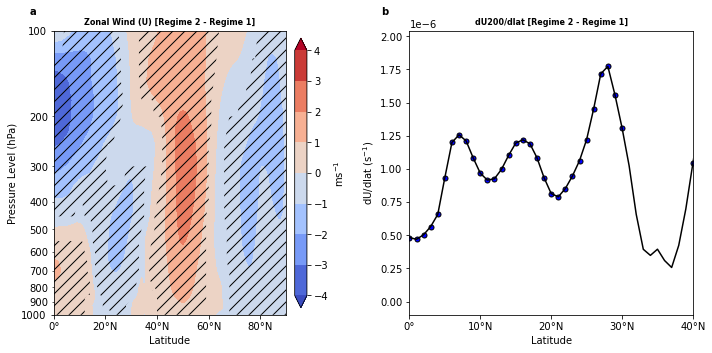

In [16]:
##### Plotting the vertical profile of zonal wind and meridional gradient of wind averaged over 50-80E

fig = plt.figure(figsize=(10,5))

ax1 = plt.subplot2grid(shape=(1, 2), loc=(0, 0), colspan=1, fig=fig)
clevs=np.arange(-4,5,1)
pvalue_mask = np.where(uwind_Regime.sig == 1, 1, np.nan)
# Set the pivot value for the colormap at 0 using TwoSlopeNorm

# Plot the trend data using contourf
diff_plot = ax1.contourf(uwind_Regime.latitude, uwind_Regime.level, uwind_Regime.dif,clevs, cmap='coolwarm',extend='both')

# Add a colorbar
cbar = fig.colorbar(diff_plot,ax=ax1,orientation='vertical', pad=0.03, shrink=0.95)
cbar.set_label(r'ms$^{-1}$')

# Add hatching to the sections where p-value is 1
hatch_plot = ax1.contourf(uwind_Regime.latitude, uwind_Regime.level, pvalue_mask, hatches=['//'],cmap='gray', alpha=0)

# Reverse the y-axis
ax1.invert_yaxis()
ax1.set_yscale('log')  # Set y-axis to log scale

# # Use ScalarFormatter to format tick labels as plain numbers
ax1.yaxis.set_major_formatter(ScalarFormatter())
ax1.yaxis.set_minor_formatter(ScalarFormatter())

# Latitude labels
ax1.set_xticks(np.arange(0,95,20))
lat_formatter = cticker.LatitudeFormatter()
ax1.xaxis.set_major_formatter(lat_formatter)

ax1.set_ylabel('Pressure Level (hPa)')
ax1.set_xlabel('Latitude')

# Title
ax1.set_title('Zonal Wind (U) [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax1.text(-0.075, 1.05, 'a',verticalalignment='bottom', horizontalalignment='right',transform=ax1.transAxes,color='k', weight='bold')

####

ax2 = plt.subplot2grid(shape=(1,2), loc=(0, 1), colspan=1, fig=fig)


ax2.plot(dUdy_Regime.latitude, dUdy_Regime.dif, color='black',linestyle='solid')

#ax2.plot(dUdy_Regime.latitude, dUdy_Regime.Regime1, color='blue',linestyle='solid')
#ax2.plot(dUdy_Regime.latitude, dUdy_Regime.Regime2, color='red',linestyle='solid')

pvalue_mask = np.where(dUdy_Regime.sig == 1, 1, np.nan)
indices = np.where(pvalue_mask == 1)
ax2.scatter(dUdy_Regime.latitude[indices], dUdy_Regime.dif[indices], color='blue', s=25, edgecolors='k')

ax2.set_xlim(0,40)
#ax2.set_ylim(4,16)

# Latitude labels
ax2.set_xticks(np.arange(0,50,10))
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lat_formatter)

# Labels and legend
ax2.set_ylabel('dU/dlat (s$^{-1}$)', fontsize=10)
ax2.set_xlabel('Latitude', fontsize=10)

# Title
ax2.set_title('dU200/dlat [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax2.text(-0.075, 1.05, 'b',verticalalignment='bottom', horizontalalignment='right',transform=ax2.transAxes,color='k', weight='bold')


plt.tight_layout()
# Save the figure
plt.savefig('Figure_2.png', dpi=600,bbox_inches='tight')
plt.savefig('Figure_2.pdf', dpi=600,bbox_inches='tight')